In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["image.cmap"] = 'magma'

from sklearn.metrics.pairwise import cosine_similarity

from damo.config.base import parse_config
from tools.demo import Infer

from my_help_functions.hooks import register_bn_hooks

In [2]:
config = parse_config('./configs/damoyolo_tinynasL20_T.py')

path = './assets/couches.jpg'

infer_engine = Infer(config, device='cuda',
    ckpt='./weights/damoyolo_tiny.pth')

model = infer_engine.model.eval()

Inference with torch engine!


In [3]:
bns = register_bn_hooks(model)

In [4]:
origin_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
image, origin_shape = infer_engine.preprocess(origin_image)
output = model(image)

In [26]:
norm_center = [(torch.linalg.norm(bns[i][0].running_mean) / torch.mean(torch.norm(bns[i][1], dim=(1, 2)))).detach().cpu() for i in range(len(bns))]
norm_after  = [(torch.mean(torch.norm(bns[i][2] * torch.sqrt(bns[i][0].running_var.view(-1, 1, 1) + bns[i][0].eps), dim=(1, 2))) / torch.mean(torch.norm(bns[i][1], dim=(1, 2)))).detach().cpu() for i in range(len(bns))]

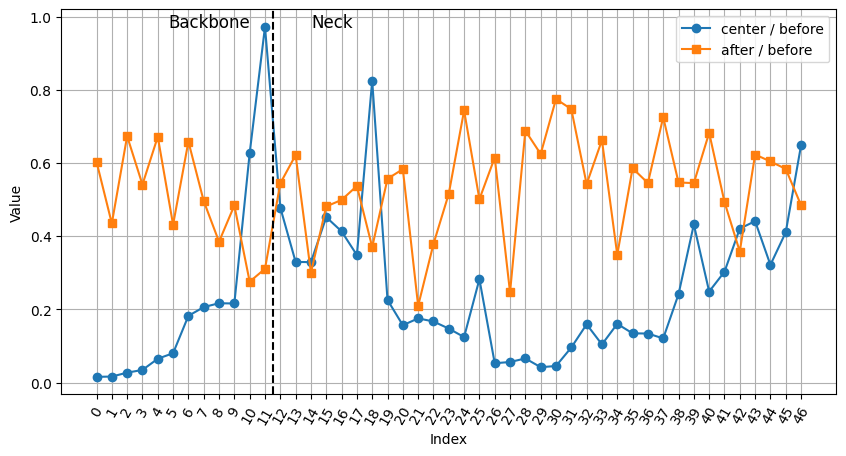

In [35]:
x = np.arange(len(bns))

plt.figure(figsize=(10, 5))

plt.plot(x, norm_center, marker='o', label='center / before', linestyle='-')
plt.plot(x, norm_after,  marker='s', label='after / before', linestyle='-')

plt.xticks(x, [str(i) for i in x], rotation=60)

plt.axvline(x=11.5, color='black', linestyle='--')

plt.text(10, max(max(norm_center), max(norm_after)), 'Backbone', ha='right', fontsize=12)
plt.text(14, max(max(norm_center), max(norm_after)), 'Neck', ha='left', fontsize=12)

plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()